## Import packages and define paths

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import verde as vd

import discretize
import SimPEG
from SimPEG import dask  # run in parallel
from SimPEG.utils import io_utils

Define paths for data files and for the prebuilt TreeMesh

In [2]:
assets_path = Path("3_blocks_model") / "Assets"
mesh_fname = assets_path / "mesh_CaMP.ubc"
gravity_fname = assets_path / "grav_data.obs"

## Load data

In [3]:
gravity_data = io_utils.read_grav3d_ubc(gravity_fname)
gravity_data

Plot the data

In [4]:
receiver_locations = gravity_data.survey.receiver_locations
easting, northing, upward = tuple(receiver_locations[:, i] for i in range(3))

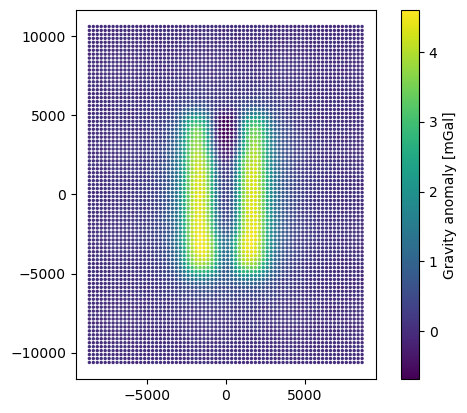

In [5]:
plt.scatter(easting, northing, c=gravity_data.dobs, s=2)
plt.colorbar(label="Gravity anomaly [mGal]")
plt.gca().set_aspect("equal")
plt.show()

## Load TreeMesh

In [6]:
mesh = discretize.TreeMesh.read_UBC(mesh_fname)
mesh

OcTreeMesh: 12.96% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  3   :       100            ---------------------------   --------------------
  4   :       636         x:   -16000.0   ,   16000.0        250.0   ,   4000.0  
  5   :      2120         y:   -16000.0   ,   16000.0        250.0   ,   4000.0  
  6   :      6368         z:    -6400.0   ,     0.0          100.0   ,   1600.0  
  7   :     126720     
-----------------------
Total :     135944

## Build the map

The map is the transformations that translates the physical properties of the cells in the mesh to the parameters of the actual inversion. The map could either be a simple transformation (like using the `log` for susceptibilities) or even complex ones. For this gravity inversion, our model parameters will be the same as the density of the cells, so we will use an `IdentityMap`.

In [7]:
identity_map = SimPEG.maps.IdentityMap(mesh)
identity_map

## Define the simulation

In order to run the inversion, we need to define our simulation.

In [8]:
simulation = SimPEG.potential_fields.gravity.simulation.Simulation3DIntegral(
    survey=gravity_data.survey,  # data
    mesh=mesh,                   # TreeMesh
    rhoMap=identity_map,         # map
)
simulation

## Run the inversion

### Assign uncertainties

In [9]:
uncertainties = np.full_like(
    gravity_data.dobs, 0.01 * vd.maxabs(gravity_data.dobs)
)
uncertainties

array([0.04601298, 0.04601298, 0.04601298, ..., 0.04601298, 0.04601298,
       0.04601298])

### Define the Survey and the Data

We already have the Data defined in the `gravity_data` object, and the survey is in the `gravity_data.survey` attribute.

In [10]:
gravity_data

In [11]:
gravity_data.survey

### Define active cells

In [12]:
active_cells = np.ones(mesh.nC, dtype=bool)
active_cells

array([ True,  True,  True, ...,  True,  True,  True])

### Define reference model

In [13]:
background_density = 1e-6  # background density in g/cm3 (should be != 0)
reference_model = background_density * np.ones(mesh.nC)

### Define inverse problem

The inverse problem is defined by:
- The **data misfit**
- The **regularization**
- The **optimization algorithm**

In [14]:
data_misfit = SimPEG.data_misfit.L2DataMisfit(
    data=gravity_data, simulation=simulation
)
data_misfit

In [15]:
regularization = SimPEG.regularization.Simple(
    mesh, indActive=active_cells, mapping=identity_map
)
regularization

For the optimization we will use a projected Gauss-Newton algorithm. It employs the conjugate gradient solver.

In [16]:
optimization = SimPEG.optimization.ProjectedGNCG(
    maxIter=20,    # max number of iterations
    lower=-1.0,    # ?
    upper=1.0,     # ?
    maxIterLS=20,  # ?
    maxIterCG=100, # ?
    tolCG=1e-4,    # ?
)
optimization

And finally set up the inversion problem

In [17]:
inversion_problem = SimPEG.inverse_problem.BaseInvProblem(
    data_misfit, regularization, optimization
)
inversion_problem

### Define inversion directives

In [18]:
# Define a starting value for the trade-off parameter (beta)
starting_beta = SimPEG.directives.BetaEstimate_ByEig(beta0_ratio=1)

# Define the fractional decrease in beta and the number of
# Gauss-Newton solves for each beta value.
beta_schedule = SimPEG.directives.BetaSchedule(coolingFactor=5, coolingRate=1)

# Update the preconditionner if it is model dependent
update_jacobi = SimPEG.directives.UpdatePreconditioner()

# Set a stopping criteria for the inversion
target_misfit = SimPEG.directives.TargetMisfit(chifact=1)

# Add sensitivity weights
sensitivity_weights = SimPEG.directives.UpdateSensitivityWeights(everyIter=False)

Build a list with the directives

In [19]:
# The directives are defined as a list.
directives = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    update_jacobi,
    target_misfit,
]

### Define the inversion

In [20]:
inversion = SimPEG.inversion.BaseInversion(
    inversion_problem,
    directives,
)
inversion

In [21]:
inverted_model = inversion.run(reference_model)
inverted_model

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/home/ssoler/mambaforge/envs/fasttimes/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TreeMesh._cellGradxStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/ssoler/mambaforge/envs/fasttimes/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TreeMesh._cellGradyStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/ssoler/mambaforge/envs/fasttimes/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TreeMesh._cellGradzStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_z. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


((3010, 3010), (5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5229, 5219))
Computing sensitivities to local ram
[                                        ] | 0% Completed | 567.03 ms

/home/ssoler/mambaforge/envs/fasttimes/lib/python3.9/site-packages/discretize/base/base_tensor_mesh.py:1019: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/home/ssoler/mambaforge/envs/fasttimes/lib/python3.9/site-packages/discretize/base/base_tensor_mesh.py:1053: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(
/home/ssoler/mambaforge/envs/fasttimes/lib/python3.9/site-packages/discretize/base/base_tensor_mesh.py:1036: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(


[########################################] | 100% Completed | 125.92 s
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.17e-01  1.73e+06  0.00e+00  1.73e+06    3.69e+02      0              
   1  8.34e-02  7.76e+05  6.80e+05  8.33e+05    3.68e+02      0              
   2  1.67e-02  3.91e+05  2.82e+06  4.39e+05    3.67e+02      0   Skip BFGS  
   3  3.34e-03  1.47e+05  9.74e+06  1.80e+05    3.60e+02      0   Skip BFGS  
   4  6.67e-04  2.58e+04  2.50e+07  4.25e+04    3.36e+02      0   Skip BFGS  
   5  1.33e-04  3.58e+03  3.74e+07  8.58e+03    2.87e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.7308e+05
0 : |xc-x_last| = 6.6000e-01 <= tolX*(1+|x0|) = 1.0004e-01
0 : |proj(x-g

array([-0.00060909, -0.00014263, -0.00023057, ..., -0.00020973,
       -0.00036619, -0.00033293])

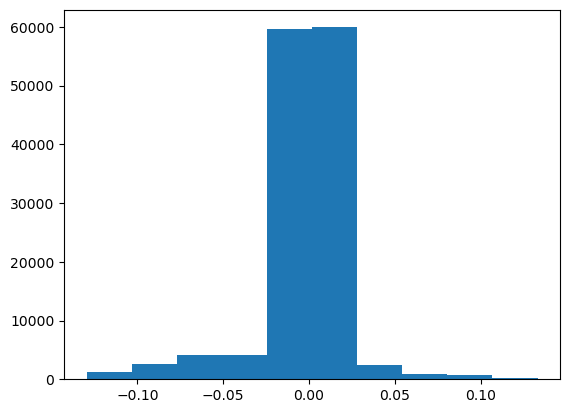

In [23]:
plt.hist(inverted_model)
plt.show()

In [48]:
maxabs = vd.maxabs(inverted_model)
clim = (-maxabs, maxabs)

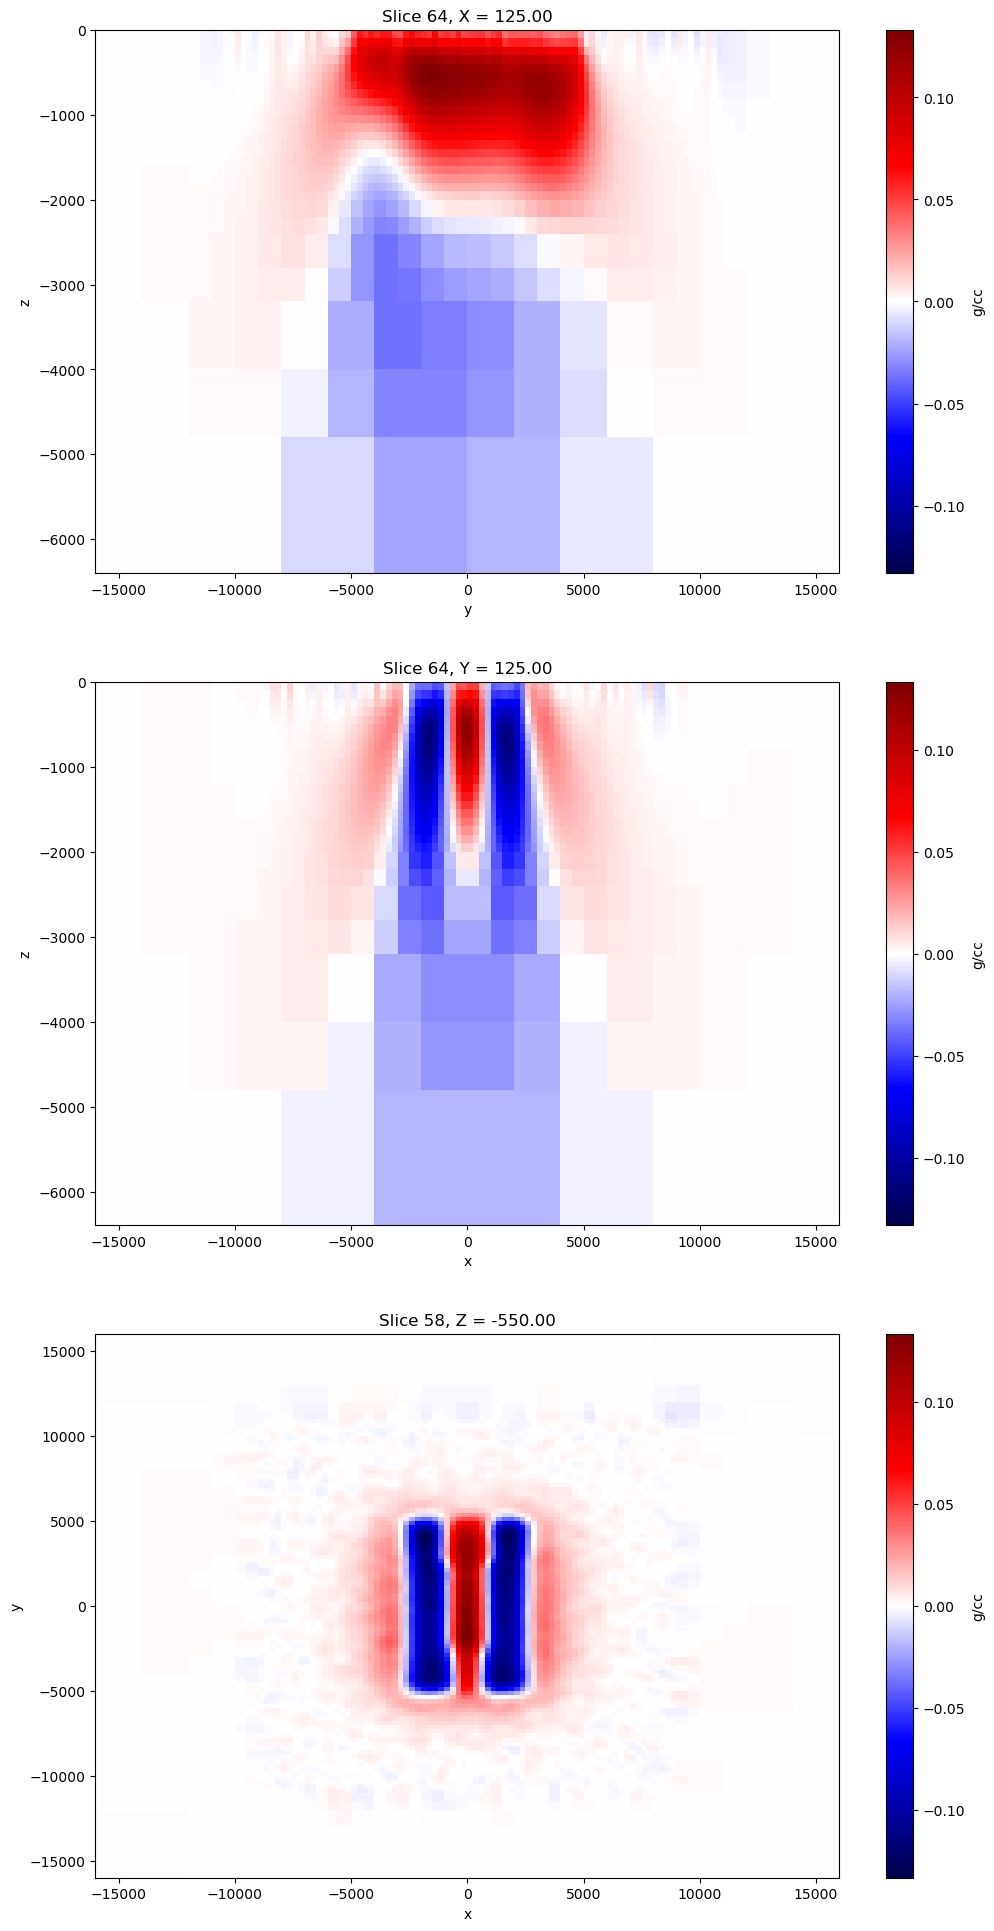

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 24))

for direction, slice_loc, ax in zip("x y z".split(), (None, None, -500), (ax1, ax2, ax3)):
    tmp, = mesh.plot_slice(
        inverted_model,
        normal=direction,
        slice_loc=slice_loc,
        clim=clim,
        ax=ax,
        pcolor_opts={"cmap": "seismic"},
    )
    plt.colorbar(tmp, ax=ax, label="g/cc")
plt.show()

In [33]:
data_predicted = simulation.dpred(inverted_model)

(array([2.258e+03, 1.759e+03, 1.102e+03, 5.620e+02, 2.190e+02, 8.900e+01,
        2.000e+01, 9.000e+00, 1.000e+00, 1.000e+00]),
 array([5.04143143e-06, 1.26062286e-02, 2.52074157e-02, 3.78086028e-02,
        5.04097899e-02, 6.30109770e-02, 7.56121642e-02, 8.82133513e-02,
        1.00814538e-01, 1.13415726e-01, 1.26016913e-01]),
 <BarContainer object of 10 artists>)

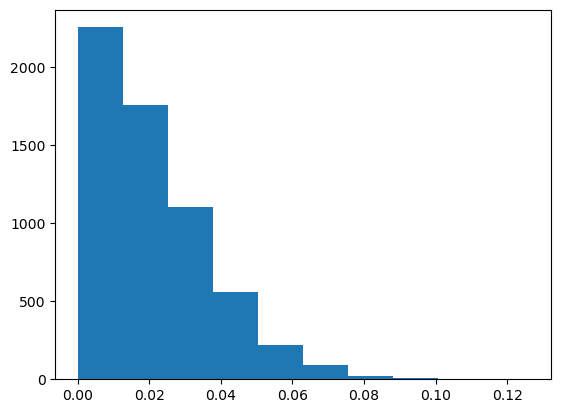

In [35]:
plt.hist(np.abs(gravity_data.dobs - data_predicted))

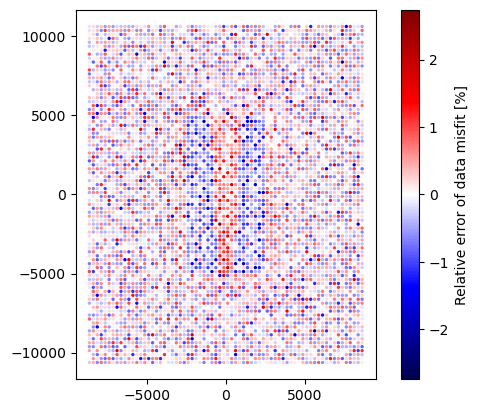

In [41]:
relative_error = (data_predicted - gravity_data.dobs) / vd.maxabs(gravity_data.dobs) * 100
maxabs = vd.maxabs(relative_error)

plt.scatter(easting, northing, c=relative_error, s=2, vmin=-maxabs, vmax=maxabs, cmap="seismic")
plt.colorbar(label="Relative error of data misfit [%]")
plt.gca().set_aspect("equal")
plt.show()